# Training with Online Algorithms

In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
import brainpy_datasets as bd

bm.set_environment(x64=True, mode=bm.batching_mode)
bm.set_platform('cpu')

bp.__version__

'2.4.0'

Online training algorithms, such as FORCE learning, have played vital roles in brain modeling. BrainPy provides ``brainpy.train.OnlineTrainer`` for model training with online algorithms.

## Train a reservoir model

Here, we are going to use ``brainpy.OnlineTrainer`` to train a [next generation reservoir computing model (NGRC)](https://doi.org/10.1038/s41467-021-25801-2) to predict chaotic dynamics.

We first get the training dataset.

In [2]:
def get_subset(data, start, end):
  res = {'x': data.xs[start: end],
         'y': data.ys[start: end],
         'z': data.zs[start: end]}
  res = bm.hstack([res['x'], res['y'], res['z']])
  # Training data must have batch size, here the batch is 1
  return res.reshape((1, ) + res.shape)

In [3]:
dt = 0.01
t_warmup, t_train, t_test = 5., 100., 50.  # ms
num_warmup, num_train, num_test = int(t_warmup/dt), int(t_train/dt), int(t_test/dt)

In [4]:
lorenz_series = bd.chaos.LorenzEq(t_warmup + t_train + t_test,
                                  dt=dt,
                                  inits={'x': 17.67715816276679,
                                         'y': 12.931379185960404,
                                         'z': 43.91404334248268})

In [5]:
X_warmup = get_subset(lorenz_series, 0, num_warmup - 5)
X_train = get_subset(lorenz_series, num_warmup - 5, num_warmup + num_train - 5)
X_test = get_subset(lorenz_series,
                    num_warmup + num_train - 5,
                    num_warmup + num_train + num_test - 5)

In [6]:
# out target data is the activity ahead of 5 time steps
Y_train = get_subset(lorenz_series, num_warmup, num_warmup + num_train)
Y_test = get_subset(lorenz_series,
                    num_warmup + num_train,
                    num_warmup + num_train + num_test)

Then, we try to build a NGRC model to predict the chaotic dynamics ahead of five time steps.

In [7]:
class NGRC(bp.DynamicalSystemNS):
  def __init__(self, num_in):
    super(NGRC, self).__init__()
    self.r = bp.layers.NVAR(num_in, delay=2, order=2, constant=True)
    self.o = bp.layers.Dense(self.r.num_out, num_in, b_initializer=None, mode=bm.training_mode)

  def update(self, x):
    return x >> self.r >> self.o

In [8]:
model = NGRC(3)
model.reset(1)

Here, we use ridge regression as the training algorithm to train the chaotic model.

In [9]:
trainer = bp.OnlineTrainer(model, fit_method=bp.algorithms.RLS(), dt=dt)

In [10]:
# first warmup the reservoir

_ = trainer.predict(X_warmup)

  0%|          | 0/495 [00:00<?, ?it/s]

In [11]:
# then fit the reservoir model

_ = trainer.fit([X_train, Y_train])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
def plot_lorenz(ground_truth, predictions):
  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(121, projection='3d')
  ax.set_title("Generated attractor")
  ax.set_xlabel("$x$")
  ax.set_ylabel("$y$")
  ax.set_zlabel("$z$")
  ax.grid(False)
  ax.plot(predictions[:, 0], predictions[:, 1], predictions[:, 2])

  ax2 = fig.add_subplot(122, projection='3d')
  ax2.set_title("Real attractor")
  ax2.grid(False)
  ax2.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2])
  plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

Prediction NMS:  0.0008616580175702455


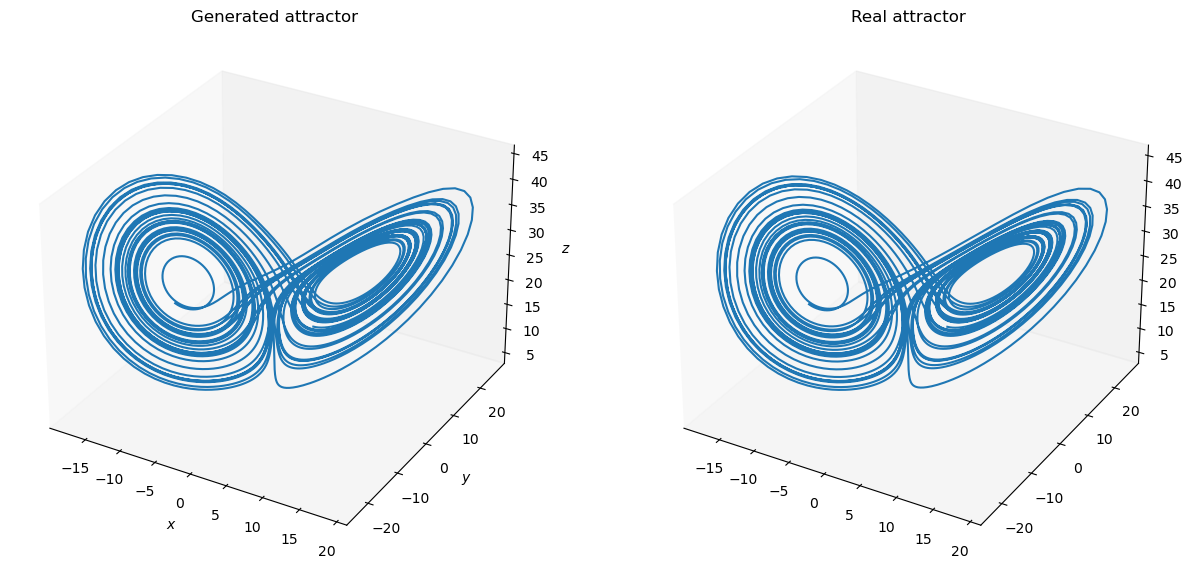

In [13]:
# finally, predict the model with the test data

outputs = trainer.predict(X_test)
print('Prediction NMS: ', bp.losses.mean_squared_error(outputs, Y_test))
plot_lorenz(bm.as_numpy(Y_test).squeeze(), bm.as_numpy(outputs).squeeze())